# Sheet 4: Solution

In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Exercise 2: Lasso regression

In [2]:
pcancer = pd.read_csv("prostate.csv",delimiter=',')

pcancer.head(8)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,True
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,True
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,True
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,True
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,True
5,-1.049822,3.228826,50,-1.386294,0,-1.386294,6,0,0.765468,True
6,0.737164,3.473518,64,0.615186,0,-1.386294,6,0,0.765468,False
7,0.693147,3.539509,58,1.536867,0,-1.386294,6,0,0.854415,True


In [3]:
# There's a training sub-dataset that we will focus on. Later, we will try to predict
# the values of the remaining observations.
col_num = 8
Xtrain = pcancer.loc[pcancer['train'] == True,pcancer.columns[0:col_num]]
ytrain = pcancer.loc[pcancer['train'] == True,pcancer.columns[col_num]]
Xtrain.head(8)
names = list(Xtrain)
Xtest = pcancer.loc[pcancer['train'] == False,pcancer.columns[0:col_num]]
ytest = pcancer.loc[pcancer['train'] == False,pcancer.columns[col_num]]
Xtest.head(8)

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45
6,0.737164,3.473518,64,0.615186,0,-1.386294,6,0
8,-0.776529,3.539509,47,-1.386294,0,-1.386294,6,0
9,0.223144,3.244544,63,-1.386294,0,-1.386294,6,0
14,1.205971,3.442019,57,-1.386294,0,-0.430783,7,5
21,2.059239,3.501043,60,1.474763,0,1.348073,7,20
24,0.385262,3.667400,69,1.599388,0,-1.386294,6,0
25,1.446919,3.124565,68,0.300105,0,-1.386294,6,0
27,-0.400478,3.865979,67,1.816452,0,-1.386294,7,20


In [4]:
# scale data sets to have zero mean and unit variance, but do not adjust lpsa
from sklearn import linear_model,preprocessing
Xtrain_mean = np.mean(Xtrain)
Xtrain_std = np.std(Xtrain)
print(Xtrain_mean)
print(Xtrain_std)
# Scale training data to have zero mean and unit variance (standard derivation)
Xtrain = (Xtrain-Xtrain_mean)/Xtrain_std

Xtest.head(8)
# Scale testing data using training mean and trainig standard derivation
Xtest = (Xtest-Xtrain_mean)/Xtrain_std

lcavol      1.313492
lweight     3.626108
age        64.746269
lbph        0.071440
svi         0.223881
lcp        -0.214203
gleason     6.731343
pgg45      26.268657
dtype: float64
lcavol      1.233282
lweight     0.473031
age         7.446011
lbph        1.452691
svi         0.416843
lcp         1.390243
gleason     0.703554
pgg45      29.082272
dtype: float64


In [5]:
from sklearn.linear_model import LinearRegression
import numpy as np
linear_reg = LinearRegression(fit_intercept=True).fit(Xtrain, ytrain)

Fit lasso 

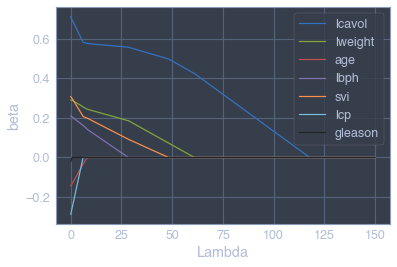

In [6]:
from sklearn.linear_model import Lasso
n_alphas = 1000
lam= np.linspace(0.0001, 150, n_alphas)

betaHats = np.zeros((n_alphas,Xtrain.shape[1]+1))
for i in range(n_alphas):
    lasso_reg = Lasso(alpha=lam[i]/(2*Xtrain.shape[0])).fit(Xtrain, ytrain)
    
    betaHats[i,1:] = lasso_reg.coef_
    betaHats[i,0] = lasso_reg.intercept_
    
plt.figure()
plt.plot(lam, betaHats[:,1:-1])
plt.xlabel('Lambda')
plt.ylabel('beta')
plt.legend(names[0:8])
plt.show()

Match the solution with coordinate descent

No handles with labels found to put in legend.


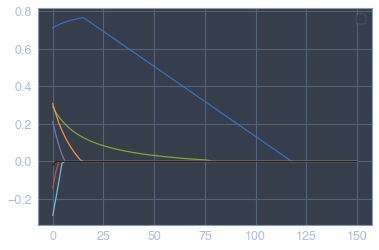

In [11]:
n_alphas = 100
lam= np.linspace(0.0001, 150, n_alphas)
X = np.concatenate((np.ones(Xtrain.shape[0]).reshape(-1,1),Xtrain),axis=1)
model_lasso_coef2 = np.zeros((lam.shape[0],9))

for i in range(n_alphas):
    coefs = np.linalg.pinv(X.T.dot(X)+lam[i]).dot(X.T).dot(ytrain)
    res = ytrain-X.dot(coefs)
    for step in range(10):
        for j in range(8):
            res = ytrain-X[:,j]*coefs[j]
            a = 2*np.sum(X[:,j]**2)
            c = 2*np.sum(X[:,j]*res)
            
            coefs[j] = (np.abs(c)-lam[i])/a
            coefs[j] = np.sign(c)*np.maximum(coefs[j],0)
            res = res-X[:,j]*coefs[j]
            
    model_lasso_coef2[i,:] = coefs    
            
plt.figure()
plt.plot(lam, model_lasso_coef2[:,1:-1])
plt.legend()
plt.show()

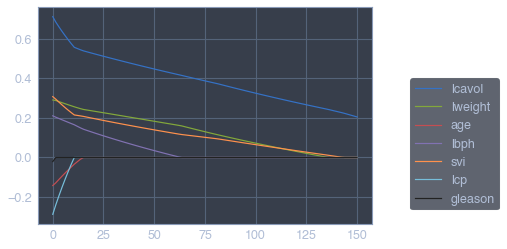

In [17]:
from sklearn.linear_model import ElasticNet

net_coefs = np.zeros((n_alphas,9))
for i in range(n_alphas):
    net = ElasticNet(lam[i]/(2*Xtrain.shape[0]), l1_ratio=0.5, fit_intercept=True).fit(Xtrain,ytrain)
    
    net_coefs[i,1:] = net.coef_
    net_coefs[:,0] = net.intercept_
    
plt.figure()
plt.plot(lam, net_coefs[:,1:-1])
plt.legend(names[:8],bbox_to_anchor=(1.4,0.7))
plt.show()

Find optimal coefficient using cross-validation

In [24]:
from sklearn.linear_model import RidgeCV,LassoCV,ElasticNetCV
optim_ridge = RidgeCV(alphas=lam, cv=5).fit(Xtrain,ytrain)
optim_lasso = LassoCV(alphas=lam/(2*Xtrain.shape[0]), cv=5).fit(Xtrain,ytrain)
optim_elastic = ElasticNetCV(alphas=lam/(2*Xtrain.shape[0]), cv=5).fit(Xtrain,ytrain)

print('optimal ridge regression strength lambda is: ',optim_ridge.alpha_)
print('optimal lasso regression strength lambda is: ',optim_lasso.alpha_*(2*Xtrain.shape[0]))
print('optimal elastic regression strength lambda is: ',optim_elastic.alpha_*(2*Xtrain.shape[0]))

optimal ridge regression strength lambda is:  124.24244141414141
optimal lasso regression strength lambda is:  0.00010000000000000002
optimal elastic regression strength lambda is:  0.00010000000000000002


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
print('$\beta$ coefficients of ridge regression',optim_ridge.coef_)
print('$\beta$ coefficients of lasso regression',optim_lasso.coef_)
print('$\beta$ coefficients of elastic regression',optim_elastic.coef_)

$eta$ coefficients of ridge regression [0.21513448 0.1484939  0.02141925 0.09065035 0.14280151 0.08341709
 0.05374744 0.08909149]
$eta$ coefficients of lasso regression [ 0.71069524  0.29042003 -0.1413067   0.21030232  0.30711583 -0.28618748
 -0.02032945  0.27461805]
$eta$ coefficients of elastic regression [ 0.7107765   0.29043278 -0.14136953  0.21035438  0.30718858 -0.28639787
 -0.02050738  0.27487208]
